In [1]:
import random
import itertools as it
import time

import pandas as pd
import numpy as np
np.random.seed(1337)


dataset_A = pd.read_csv('../TSPA.csv', sep=';', names=['x', 'y', 'cost'])
dataset_B = pd.read_csv('../TSPB.csv', sep=';', names=['x', 'y', 'cost'])

datasets = [dataset_A, dataset_B]

dataset_A.shape, dataset_B.shape

((200, 3), (200, 3))

In [2]:
node1, node2 = dataset_B.iloc[177], dataset_B.iloc[43]

print(f'{node1}\n\n{node2}')

x       1450
y        398
cost      52
Name: 177, dtype: int64

x       1654
y       1486
cost     638
Name: 43, dtype: int64


In [3]:
def euclidean_distance(node1, node2):
    return np.int32(((node1['x'] - node2['x']) ** 2 + (node1['y'] - node2['y']) ** 2) ** 0.5 + 0.5)

In [4]:
print(f'distance between node1 and node2 = {euclidean_distance(node1, node2)}')

distance between node1 and node2 = 1107


In [5]:
def nodes_cost(node1, node2):
    return node1['cost'] + node2['cost']

In [6]:
print(f'objective function of node1 and node2 = {euclidean_distance(node1, node2) + nodes_cost(node1, node2)}')

objective function of node1 and node2 = 1797


In [7]:
def calculate_function_cost(dataset):
    cost = dataset["cost"].sum()
    for i in range(-1, len(dataset) - 1):
        cost += euclidean_distance(dataset.iloc[i], dataset.iloc[i + 1])
    return int(cost)

In [8]:
def calculate_distance_matrix(dataset):
    n_nodes = len(dataset)
    distance_matrix = np.zeros((n_nodes, n_nodes), dtype=np.float64)
    for i, j in it.product(range(n_nodes), range(n_nodes)):
        if i == j:
            continue
        a, b = dataset.iloc[i], dataset.iloc[j]
        distance_matrix[i, j] = euclidean_distance(a, b) + nodes_cost(a, b)
    return distance_matrix

In [9]:
distance_matrix_A = calculate_distance_matrix(dataset_A)
distance_matrix_B = calculate_distance_matrix(dataset_B)

In [10]:
print(f'objective function of node1 and node2 = {distance_matrix_A[177, 43]}')

objective function of node1 and node2 = 1831.0


In [11]:
import matplotlib.pyplot as plt

import seaborn as sns

def plot(dataset, solution, title):
    max_x = dataset['x'].max()
    max_y = dataset['y'].max()

    aspect_ratio = int(max_x / max_y)

    if max_x > max_y:
        height = 6.0
        width = height * aspect_ratio
    else:
        width = 6.0
        height = width * aspect_ratio

    sns.set_theme(rc={'figure.figsize': (width, height)})

    sns.scatterplot(
        data=dataset,
        x='x',
        y='y',
        size='cost',
        legend=False
    )

    for i in range(-1, len(solution) - 1):
        idx1 = solution[i]
        idx2 = solution[i + 1]
        x_values = [dataset.loc[idx1, "x"], dataset.loc[idx2, "x"]]
        y_values = [dataset.loc[idx1, "y"], dataset.loc[idx2, "y"]]
        plt.plot(
            x_values,
            y_values,
            color="b",
            linestyle="-",
        )
    

    
    plt.title(title)
    plt.show();

In [12]:
def experiment(dataset, distance_matrix, title, function, **kwargs):
    start_time = time.time()
    ratings = []
    for i in range(200):
        greedy_cycle_solution = function(dataset, distance_matrix, i, **kwargs)
        solution = list(greedy_cycle_solution.index)
        ratings.append((solution, calculate_function_cost(greedy_cycle_solution)))

    best = sorted(ratings, key=lambda x: x[1])[0]
    minimum = sorted(ratings, key=lambda x: x[1])[0][1]
    mean = sum([obj_function for _, obj_function in ratings]) / len(ratings)
    maximum = sorted(ratings, key=lambda x: x[1])[-1][1]
    end_time = time.time()

    print(f"Best solution: {best[0]}")
    print(f"Time to calculate: {(end_time - start_time):.4f}")
    print("Objective function statistics:")
    print(f"{minimum = }\n{mean = }\n{maximum = }")
    plot(dataset, best[0], title=title)

# Local Search



In [13]:
def init_random_solution(dataset: pd.DataFrame, distance_matrix: pd.DataFrame, start: int) -> pd.DataFrame:
    return dataset.sample(n=int(len(dataset) * 0.5 + 0.5))

In [14]:
def init_greedy_cycle(dataset: pd.DataFrame, distance_matrix: pd.DataFrame, start: int) -> pd.Series:
    size = int(len(dataset) * 0.5 + 0.5)
    num_nodes = len(dataset)

    distance_matrix = distance_matrix.copy()

    remaining_nodes = set(range(num_nodes))
    remaining_nodes.remove(start)
    solution = [start]

    nearest_node = np.argmin(distance_matrix[start, list(remaining_nodes)])
    nearest_node_idx = list(remaining_nodes)[nearest_node]
    solution.append(nearest_node_idx)
    remaining_nodes.remove(nearest_node_idx)

    while len(solution) < size:
        best_insertion_cost = float("inf")
        best_insertion = None

        for node_idx in remaining_nodes:
            for i in range(len(solution)):
                next_i = (i + 1) % len(solution)

                current_cost = (
                    distance_matrix[solution[i], node_idx]
                    + distance_matrix[node_idx, solution[next_i]]
                    - distance_matrix[solution[i], solution[next_i]]
                )

                if current_cost < best_insertion_cost:
                    best_insertion_cost = current_cost
                    best_insertion = (node_idx, i)

        solution.insert(best_insertion[1] + 1, best_insertion[0])
        remaining_nodes.remove(best_insertion[0])

    return dataset.loc[solution]

In [15]:
def objective_change_two_nodes(dm: np.ndarray, solution: list, i: int, j: int) -> float:
    if i == j:
        return 0.0

    n = len(solution)
    a, b = solution[i], solution[j]

    a_prev = solution[i - 1] if i > 0 else solution[-1]
    a_next = solution[(i + 1) % n]
    b_prev = solution[j - 1] if j > 0 else solution[-1]
    b_next = solution[(j + 1) % n]

    # Edges to be removed and added
    edges_removed = []
    edges_added = []

    # Remove edges connected to a and b
    if a_prev not in (a, b):
        edges_removed.append((a_prev, a))
        edges_added.append((a_prev, b))
    if a_next not in (a, b):
        edges_removed.append((a, a_next))
        edges_added.append((b, a_next))
    if b_prev not in (a, b):
        edges_removed.append((b_prev, b))
        edges_added.append((b_prev, a))
    if b_next not in (a, b):
        edges_removed.append((b, b_next))
        edges_added.append((a, b_next))

    # Calculate delta
    delta = -sum(dm[u, v] for u, v in edges_removed) + sum(
        dm[u, v] for u, v in edges_added
    )

    return delta


def objective_change_two_edges(dm: np.ndarray, solution: list, i: int, j: int) -> float:
    if i >= j or (i == 0 and j == len(solution) - 1):
        return 0.0

    n = len(solution)
    a_prev = solution[i - 1] if i > 0 else solution[-1]
    a = solution[i]
    b = solution[j]
    b_next = solution[(j + 1) % n]

    # Edges before and after reversal
    cost_before = dm[a_prev, a] + dm[b, b_next]
    cost_after = dm[a_prev, b] + dm[a, b_next]

    delta = cost_after - cost_before

    return delta


def objective_change_inter_route(
    dm: np.ndarray, solution: list, i: int, vacant_node: int, node_costs: list
) -> float:
    n = len(solution)
    node_in_solution = solution[i]
    prev_node = solution[i - 1] if i > 0 else solution[-1]
    next_node = solution[(i + 1) % n]

    # Edge costs before and after the swap
    edge_cost_before = dm[prev_node, node_in_solution] + dm[node_in_solution, next_node]
    edge_cost_after = dm[prev_node, vacant_node] + dm[vacant_node, next_node]

    # Node costs before and after the swap
    node_cost_before = node_costs[node_in_solution]
    node_cost_after = node_costs[vacant_node]

    delta = (edge_cost_after - node_cost_after) - (edge_cost_before - node_cost_before)

    return delta


def two_nodes_exchange(solution: list, i: int, j: int) -> list:
    new_solution = solution.copy()
    new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
    return new_solution


def two_edges_exchange(solution: list, i: int, j: int) -> list:
    if i >= j:
        return solution.copy()  # No change if i >= j

    new_solution = solution.copy()
    new_solution[i : j + 1] = new_solution[i : j + 1][::-1]
    return new_solution


def inter_route_swap(
    solution: list,
    i: int,
    vacant_node: int,
    selected_nodes: set,
    non_selected_nodes: set,
) -> tuple:
    new_solution = solution.copy()
    node_in_solution = new_solution[i]
    new_solution[i] = vacant_node

    # Update the node sets
    selected_nodes = selected_nodes.copy()
    non_selected_nodes = non_selected_nodes.copy()

    selected_nodes.remove(node_in_solution)
    selected_nodes.add(vacant_node)
    non_selected_nodes.remove(vacant_node)
    non_selected_nodes.add(node_in_solution)

    return new_solution, selected_nodes, non_selected_nodes


def get_remaining_nodes(selected_nodes: set, num_nodes: int) -> set:
    return set(range(num_nodes)) - selected_nodes


def browse_intra_solutions(dm: np.ndarray, solution: list, intra_search: str) -> tuple:
    intra_neighbors = []
    n = len(solution)
    for i in range(n):
        for j in range(i + 1, n):
            if intra_search == "node":
                delta_nodes = objective_change_two_nodes(dm, solution, i, j)
                if delta_nodes < 0:
                    intra_neighbors.append((i, j, delta_nodes, "node"))
            elif intra_search == "edge":
                delta_edges = objective_change_two_edges(dm, solution, i, j)
                if delta_edges < 0:
                    intra_neighbors.append((i, j, delta_edges, "edge"))
    return intra_neighbors


def browse_inter_solutions(
    dm: np.ndarray, solution: list, non_selected_nodes: set, costs: list
) -> list:
    inter_neighbors = []
    for i in range(len(solution)):
        for vacant_node in non_selected_nodes:
            inter_delta = objective_change_inter_route(
                dm, solution, i, vacant_node, costs
            )
            if inter_delta < 0:
                inter_neighbors.append((i, vacant_node, inter_delta, "inter"))
    return inter_neighbors


def update_solution(
    solution: list,
    best_neighbor: tuple,
    selected_nodes: set,
    non_selected_nodes: set,
) -> tuple:
    neighbor_type = best_neighbor[-1]

    if neighbor_type == "node":
        i, j = best_neighbor[:2]
        solution = two_nodes_exchange(solution, int(i), int(j))
    elif neighbor_type == "edge":
        i, j = best_neighbor[:2]
        solution = two_edges_exchange(solution, int(i), int(j))
    elif neighbor_type == "inter":
        i, vacant_node = best_neighbor[:2]
        solution, selected_nodes, non_selected_nodes = inter_route_swap(
            solution, int(i), int(vacant_node), selected_nodes, non_selected_nodes
        )
    return solution, selected_nodes, non_selected_nodes


def local_search(
    dataset: pd.DataFrame,
    distance_matrix: np.ndarray,
    initial_solution: list,
    strategy: str = "greedy",
    intra_search: str = "edge",
    debug_mode: bool = True,
) -> pd.DataFrame:
    num_nodes = len(distance_matrix)
    initial_cost = calculate_function_cost(dataset.loc[initial_solution])

    solution = initial_solution.copy()
    selected_nodes = set(initial_solution)
    non_selected_nodes = get_remaining_nodes(selected_nodes, num_nodes)

    while True:
        intra_neighbors = browse_intra_solutions(distance_matrix, solution, intra_search)
        inter_neighbors = browse_inter_solutions(
            distance_matrix, solution, non_selected_nodes, dataset["cost"].tolist()
        )

        all_neighbors = intra_neighbors + inter_neighbors

        if not all_neighbors:
            # No improvement found
            break

        if strategy == "greedy":
            random.shuffle(all_neighbors)
            best_neighbor = next((n for n in all_neighbors if n[2] < 0), None)
        elif strategy == "steepest":
            best_neighbor = min(all_neighbors, key=lambda x: x[2])

        if best_neighbor is None:
            # No improving neighbor found
            break

        # Save the old solution for debugging
        old_solution = solution.copy()

        # Update solution and cost
        solution, selected_nodes, non_selected_nodes = update_solution(
            solution, best_neighbor, selected_nodes, non_selected_nodes
        )
        initial_cost += best_neighbor[2]

        if debug_mode:
            # Calculate real improvement
            real_improvement = calculate_function_cost(dataset.loc[old_solution]) - calculate_function_cost(
                dataset.loc[solution]
            )

            if real_improvement != -best_neighbor[2]:
                print(f"Promised improvement: {best_neighbor[2]}")
                print(f"Real improvement: {real_improvement}")
                print(f"Operation: {best_neighbor[-1]}")
                print("===========")

            assert calculate_function_cost(dataset.loc[solution]) < calculate_function_cost(dataset.loc[old_solution])

    return dataset.loc[solution]

In [16]:
def init_local_search(
    dataset: pd.DataFrame,
    distance_matrix: np.ndarray,
    start: int,
    strategy: str,
    intra_search: str,
    debug_mode: bool = True,
    algo_to_enchance: str = "greedy_cycle",
) -> pd.DataFrame:
    if algo_to_enchance == "greedy_cycle":
        solution = list(init_greedy_cycle(dataset, distance_matrix, start).index)
    elif algo_to_enchance == "random":
        solution = list(init_random_solution(dataset, distance_matrix, start).index)
    solution = local_search(dataset, distance_matrix, solution, strategy, intra_search, debug_mode)
    return solution

In [17]:
algos = ["random", "greedy_cycle"]
intra_search = ["node", "edge"]
strategy = ["greedy", "steepest"]

Best solution: [18, 183, 89, 23, 186, 114, 144, 14, 164, 27, 90, 81, 16, 171, 175, 113, 56, 31, 157, 196, 179, 185, 40, 119, 165, 138, 49, 102, 62, 167, 152, 97, 1, 101, 75, 86, 53, 180, 63, 79, 133, 151, 59, 65, 116, 43, 42, 34, 54, 177, 10, 184, 160, 181, 41, 139, 46, 117, 143, 0, 51, 80, 189, 2, 129, 57, 55, 178, 106, 52, 92, 145, 78, 25, 44, 120, 82, 176, 137, 15, 9, 37, 148, 124, 94, 122, 162, 123, 127, 70, 135, 154, 100, 26, 121, 118, 115, 193, 159, 22]
Time to calculate: 2821.7331
Objective function statistics:
minimum = 80880
mean = 85999.455
maximum = 92908


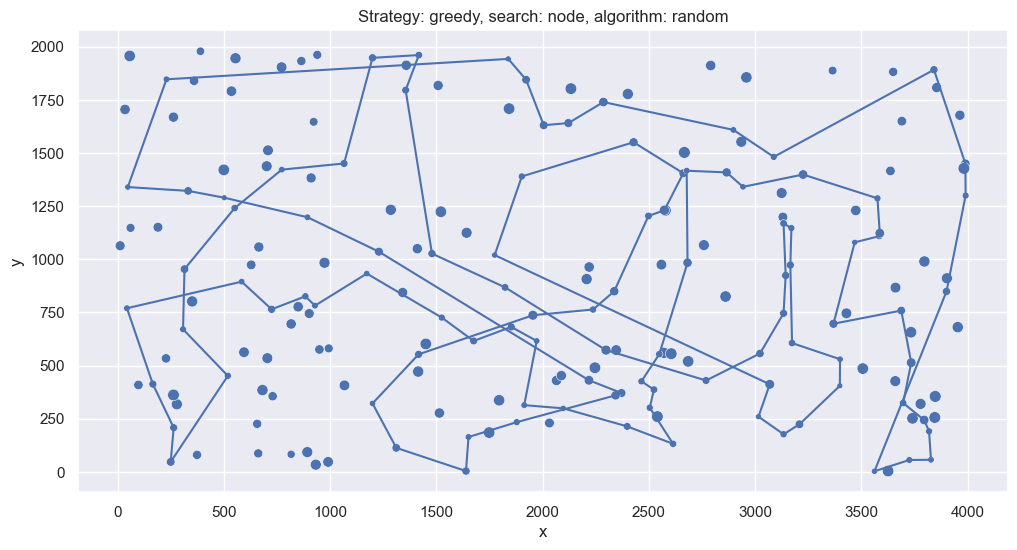

Best solution: [68, 41, 193, 159, 22, 146, 195, 181, 42, 43, 116, 65, 131, 149, 123, 135, 133, 151, 162, 35, 84, 4, 112, 59, 118, 115, 139, 46, 176, 80, 100, 26, 97, 1, 152, 2, 129, 178, 106, 52, 55, 57, 92, 145, 78, 25, 44, 120, 75, 101, 86, 63, 79, 51, 184, 160, 48, 177, 54, 30, 34, 18, 69, 108, 140, 93, 117, 0, 143, 183, 89, 186, 23, 137, 180, 154, 53, 121, 94, 124, 148, 9, 62, 49, 16, 171, 175, 113, 31, 196, 40, 90, 27, 39, 165, 119, 185, 14, 144, 15]
Time to calculate: 1501.9223
Objective function statistics:
minimum = 79540
mean = 88103.225
maximum = 97655


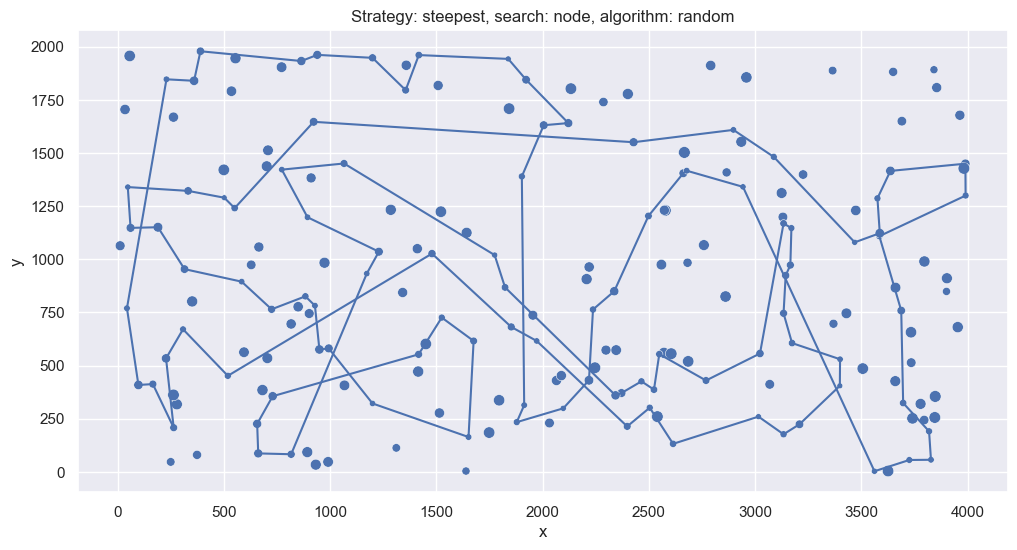

Best solution: [152, 1, 97, 26, 100, 86, 101, 75, 2, 129, 82, 120, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 92, 57, 55, 52, 178, 106, 185, 179, 157, 196, 81, 90, 40, 119, 165, 138, 14, 144, 49, 102, 62, 9, 148, 15, 186, 137, 23, 89, 183, 143, 0, 117, 93, 68, 139, 108, 18, 22, 159, 193, 41, 34, 160, 54, 177, 184, 84, 4, 112, 131, 149, 65, 116, 43, 42, 115, 46, 118, 59, 51, 176, 80, 63, 79, 133, 151, 162, 123, 127, 70, 135, 154, 180, 53, 121, 189, 94, 124]
Time to calculate: 2480.2283
Objective function statistics:
minimum = 71911
mean = 73976.24
maximum = 77565


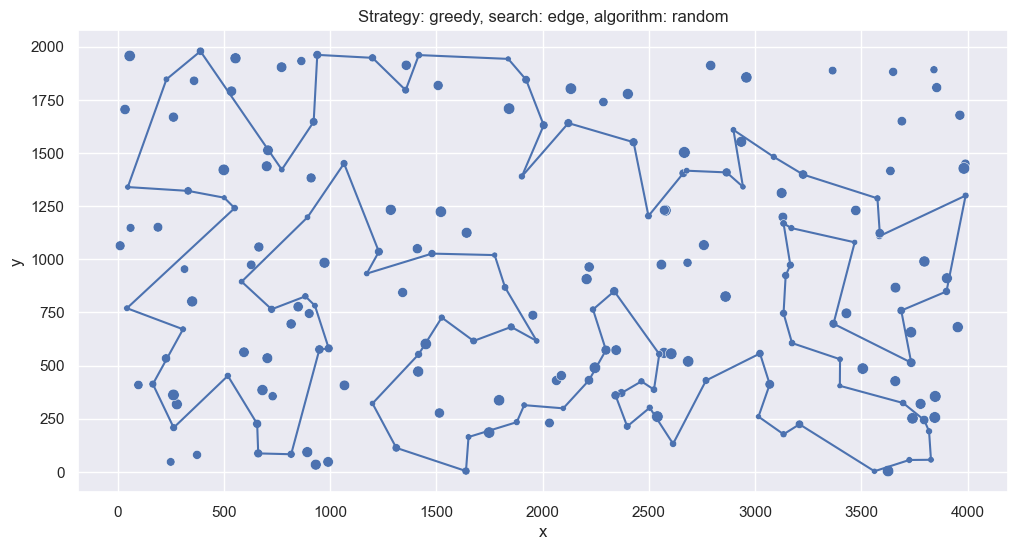

Best solution: [176, 51, 151, 162, 133, 80, 79, 63, 94, 97, 152, 148, 9, 62, 102, 144, 14, 49, 178, 106, 52, 55, 185, 40, 165, 27, 90, 81, 196, 31, 113, 175, 171, 16, 78, 145, 92, 57, 129, 82, 25, 44, 120, 2, 75, 86, 101, 1, 26, 100, 121, 53, 158, 180, 154, 135, 70, 127, 123, 149, 131, 35, 184, 84, 112, 4, 190, 10, 177, 54, 48, 160, 34, 146, 22, 181, 42, 5, 43, 116, 65, 59, 118, 115, 46, 139, 41, 193, 159, 18, 108, 93, 117, 0, 143, 183, 89, 186, 23, 137]
Time to calculate: 660.9445
Objective function statistics:
minimum = 70939
mean = 73855.835
maximum = 77610


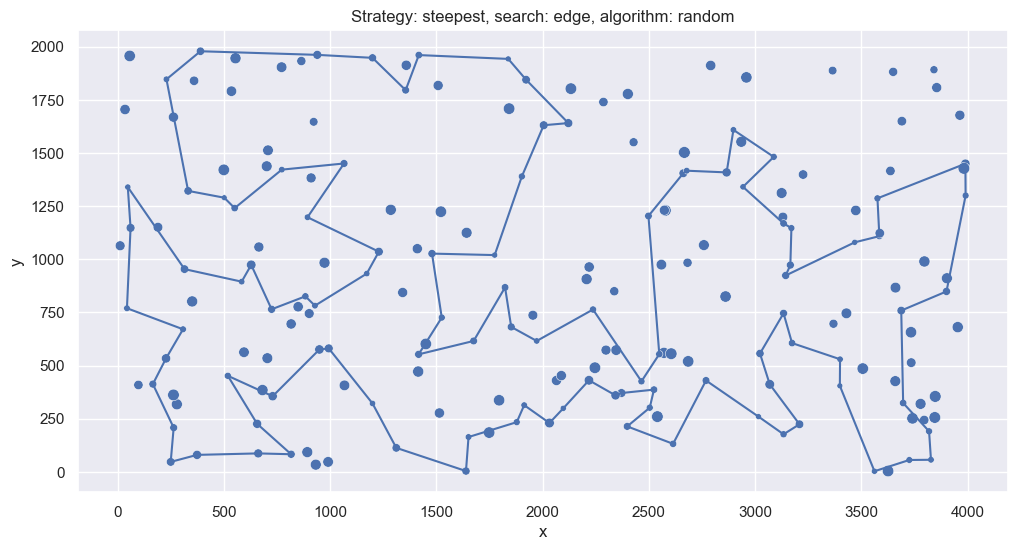

Best solution: [198, 115, 139, 41, 193, 159, 108, 18, 22, 146, 181, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 184, 42, 43, 116, 65, 149, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 100, 26, 86, 101, 75, 120, 44, 25, 16, 171, 175, 113, 31, 78, 145, 179, 196, 81, 40, 90, 27, 164, 39, 165, 185, 106, 178, 14, 144, 62, 9, 148, 102, 49, 52, 55, 57, 92, 129, 2, 1, 97, 152, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 68, 46]
Time to calculate: 103.0191
Objective function statistics:
minimum = 70564
mean = 71409.135
maximum = 72444


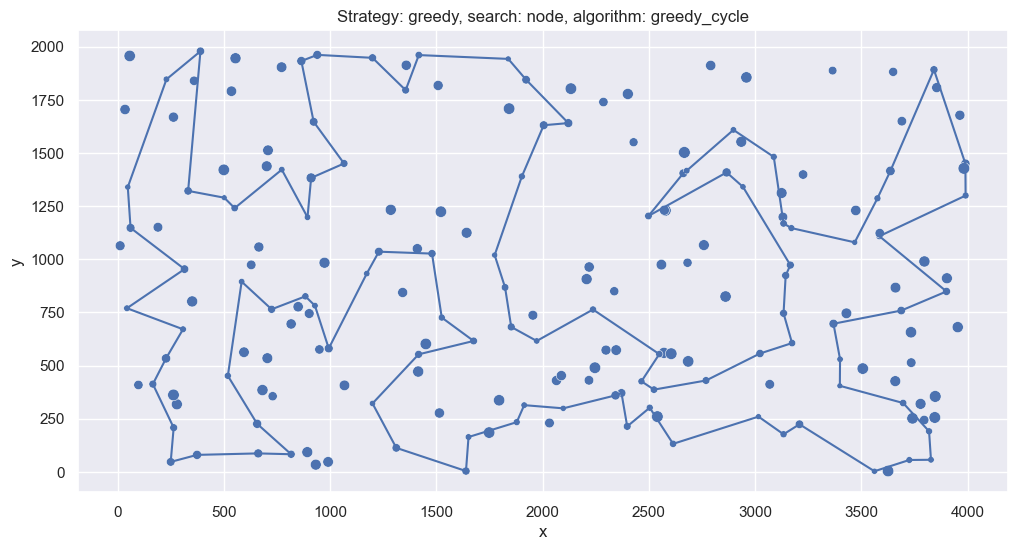

Best solution: [198, 115, 139, 41, 193, 159, 108, 18, 22, 146, 181, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 184, 42, 43, 116, 65, 149, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 100, 26, 86, 101, 75, 120, 44, 25, 16, 171, 175, 113, 31, 78, 145, 179, 196, 81, 40, 90, 27, 164, 39, 165, 185, 106, 178, 14, 144, 62, 9, 148, 102, 49, 52, 55, 57, 92, 129, 2, 1, 97, 152, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 68, 46]
Time to calculate: 96.2969
Objective function statistics:
minimum = 70564
mean = 71408.27
maximum = 72444


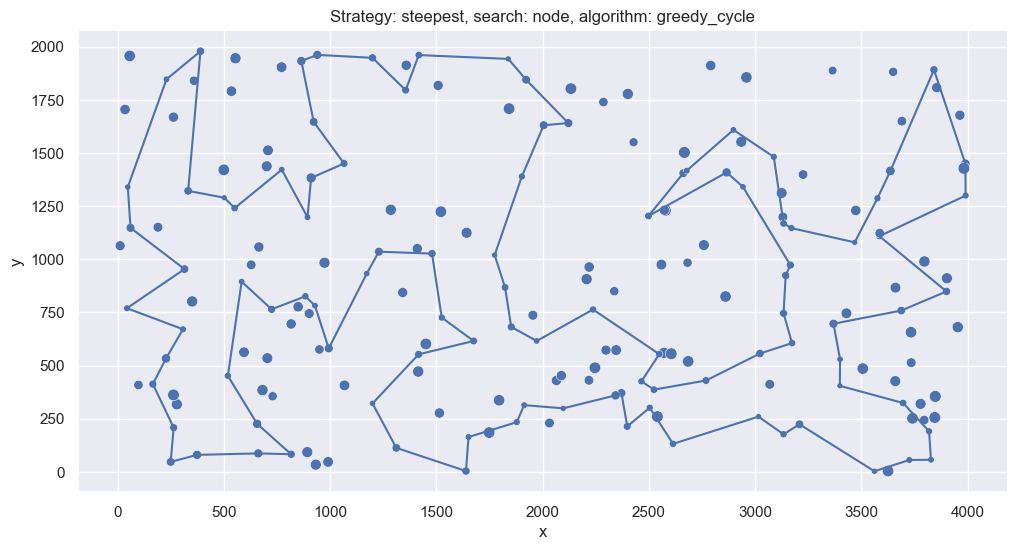

Best solution: [59, 118, 51, 151, 133, 162, 149, 131, 123, 127, 70, 135, 154, 180, 53, 100, 26, 86, 101, 75, 120, 44, 25, 16, 171, 175, 113, 31, 78, 145, 179, 196, 81, 40, 90, 27, 39, 165, 185, 106, 178, 14, 144, 62, 9, 148, 102, 49, 52, 55, 57, 92, 129, 2, 1, 97, 152, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 68, 46, 115, 139, 41, 193, 159, 108, 18, 22, 146, 181, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 184, 42, 43, 116, 65]
Time to calculate: 95.7045
Objective function statistics:
minimum = 70322
mean = 71282.905
maximum = 72378


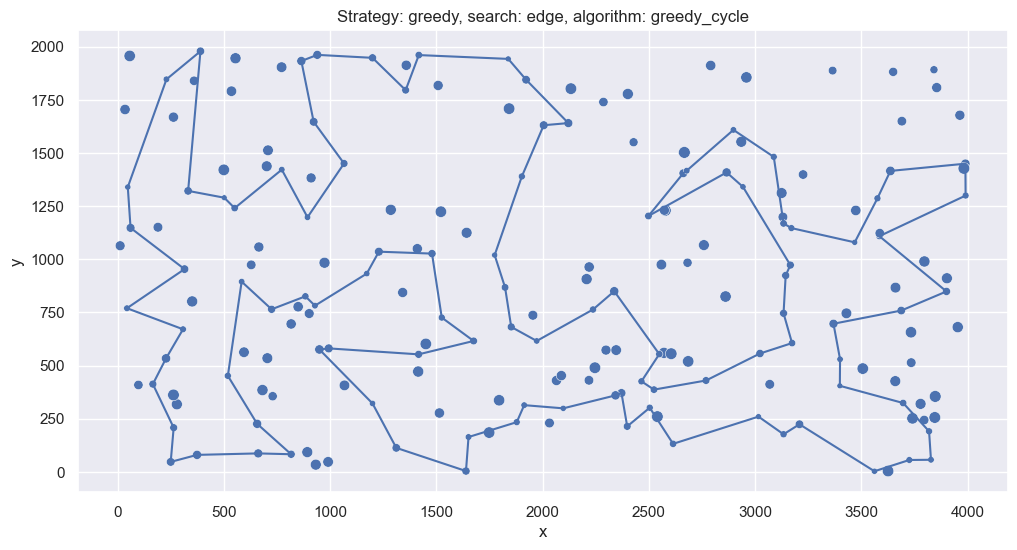

Best solution: [162, 133, 151, 51, 118, 59, 149, 131, 65, 116, 43, 42, 184, 84, 112, 4, 190, 10, 177, 54, 48, 160, 34, 181, 146, 22, 18, 108, 159, 193, 41, 139, 115, 46, 68, 140, 93, 117, 0, 143, 183, 89, 186, 23, 137, 176, 80, 79, 63, 94, 124, 152, 97, 1, 2, 129, 92, 57, 55, 52, 49, 102, 148, 9, 62, 144, 14, 178, 106, 185, 165, 39, 27, 90, 40, 81, 196, 179, 145, 78, 31, 113, 175, 171, 16, 25, 44, 120, 75, 101, 86, 26, 100, 53, 180, 154, 135, 70, 127, 123]
Time to calculate: 88.0746
Objective function statistics:
minimum = 70174
mean = 71259.05
maximum = 72378


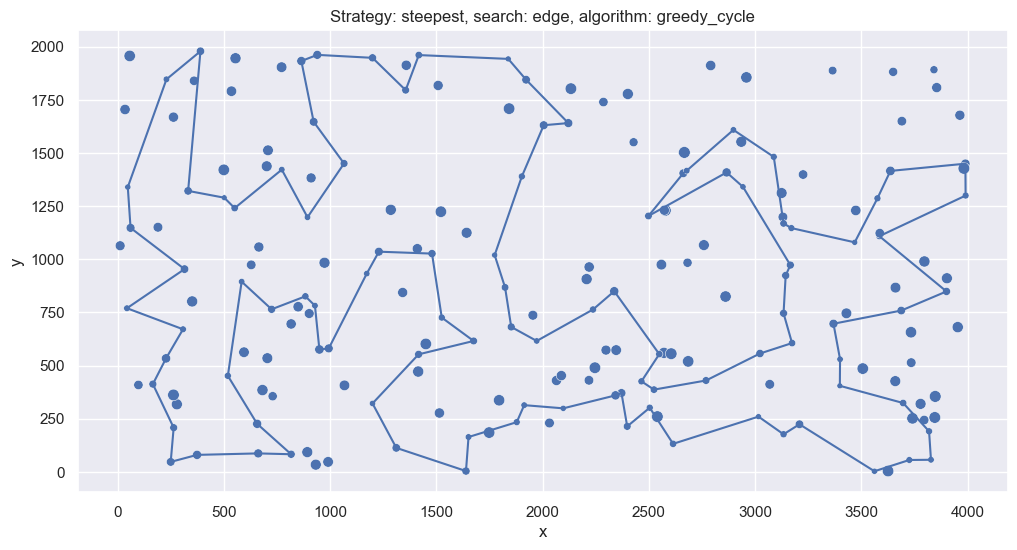

In [18]:
for algo in algos:
    for search in intra_search:
        for strat in strategy:
            experiment(
                dataset_A,
                distance_matrix_A,
                f"Strategy: {strat}, search: {search}, algorithm: {algo}",
                init_local_search,
                **{
                    "strategy": strat,
                    "intra_search": search,
                    "debug_mode": True,
                    "algo_to_enchance": algo,
                },
            )

Best solution: [143, 159, 119, 81, 153, 187, 137, 114, 127, 111, 144, 104, 8, 82, 87, 21, 177, 25, 182, 138, 11, 139, 107, 40, 63, 135, 122, 131, 121, 117, 54, 31, 190, 80, 45, 5, 142, 175, 78, 36, 61, 141, 97, 77, 180, 176, 194, 166, 185, 179, 94, 47, 148, 20, 28, 149, 140, 183, 55, 18, 62, 113, 103, 89, 163, 35, 109, 29, 145, 15, 3, 70, 134, 118, 51, 90, 133, 10, 178, 147, 188, 169, 132, 13, 195, 168, 33, 160, 0, 106, 124, 128, 86, 95, 130, 152, 184, 155, 170, 34]
Time to calculate: 2991.7574
Objective function statistics:
minimum = 54698
mean = 61198.88
maximum = 68702


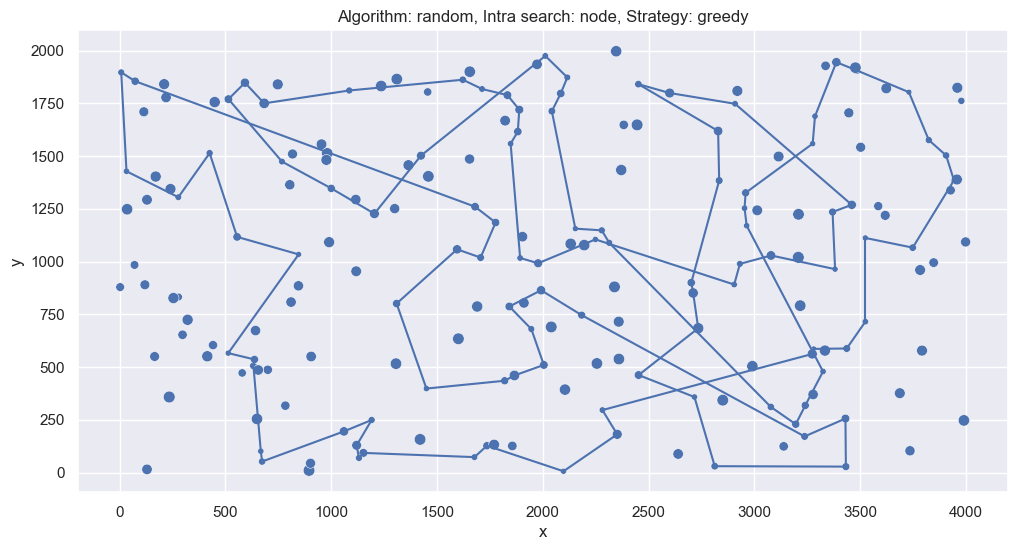

Best solution: [107, 133, 10, 147, 6, 70, 3, 15, 145, 195, 168, 139, 11, 182, 138, 33, 160, 144, 104, 177, 5, 142, 78, 36, 91, 61, 54, 31, 193, 117, 121, 112, 73, 136, 190, 80, 175, 141, 77, 97, 187, 165, 137, 127, 153, 81, 111, 189, 155, 152, 149, 28, 140, 183, 103, 89, 163, 18, 55, 34, 8, 21, 87, 82, 62, 95, 86, 176, 180, 166, 185, 99, 20, 60, 148, 47, 94, 179, 194, 113, 106, 124, 143, 35, 109, 0, 29, 13, 132, 169, 188, 134, 74, 118, 51, 90, 122, 135, 63, 40]
Time to calculate: 1036.5112
Objective function statistics:
minimum = 55813
mean = 62862.19
maximum = 73074


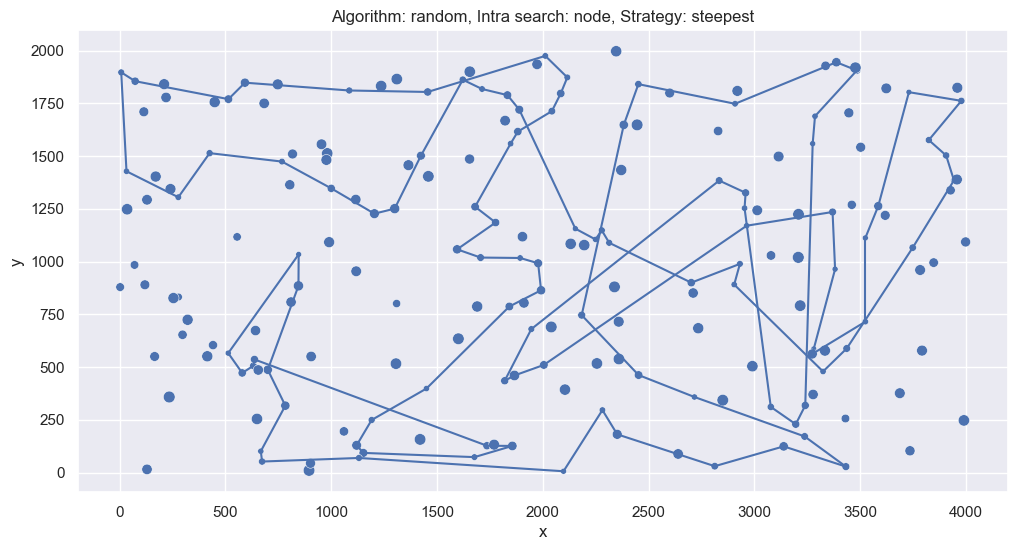

Best solution: [80, 45, 175, 78, 5, 177, 104, 8, 111, 82, 21, 61, 36, 91, 141, 77, 153, 163, 89, 127, 103, 113, 180, 176, 194, 166, 86, 185, 95, 130, 99, 22, 179, 66, 94, 47, 148, 60, 23, 20, 28, 149, 140, 183, 152, 184, 155, 170, 34, 55, 18, 62, 124, 106, 143, 35, 109, 0, 29, 144, 160, 33, 138, 182, 11, 139, 168, 195, 13, 145, 15, 3, 70, 132, 169, 188, 6, 134, 147, 51, 121, 131, 90, 122, 135, 63, 38, 27, 16, 197, 1, 156, 198, 117, 193, 54, 31, 164, 73, 190]
Time to calculate: 49705.1481
Objective function statistics:
minimum = 45466
mean = 48446.135
maximum = 52363


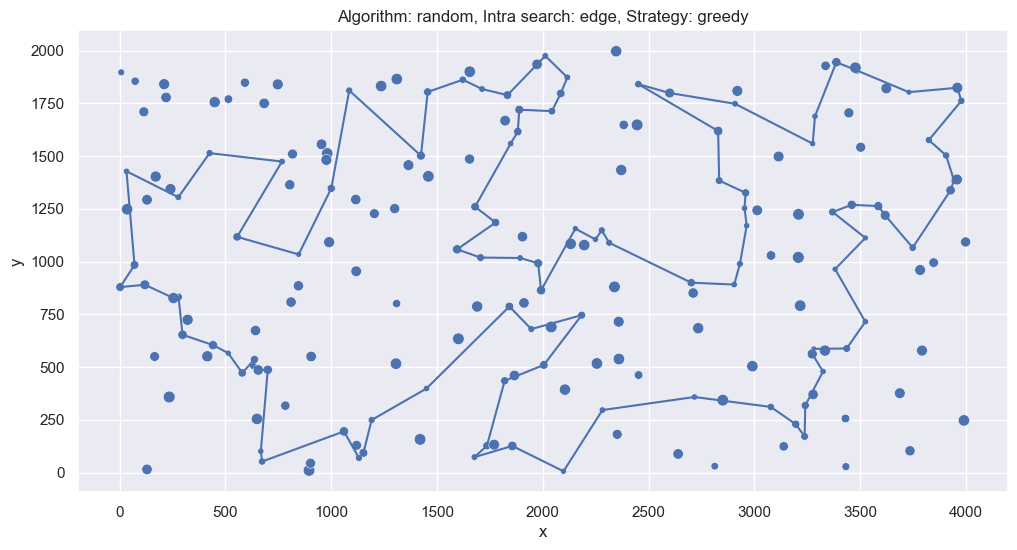

Best solution: [5, 175, 80, 190, 136, 73, 54, 31, 193, 117, 198, 156, 1, 16, 27, 38, 102, 63, 32, 135, 122, 133, 10, 191, 90, 131, 121, 51, 147, 6, 188, 169, 132, 13, 195, 168, 145, 15, 70, 3, 155, 189, 109, 35, 0, 29, 11, 139, 138, 33, 160, 104, 8, 111, 41, 159, 143, 106, 124, 128, 62, 18, 55, 34, 170, 152, 183, 140, 4, 149, 28, 20, 60, 148, 47, 94, 66, 179, 185, 130, 95, 86, 166, 194, 176, 113, 114, 127, 89, 103, 163, 187, 153, 81, 77, 141, 91, 61, 36, 177]
Time to calculate: 634.1382
Objective function statistics:
minimum = 45319
mean = 48296.625
maximum = 50992


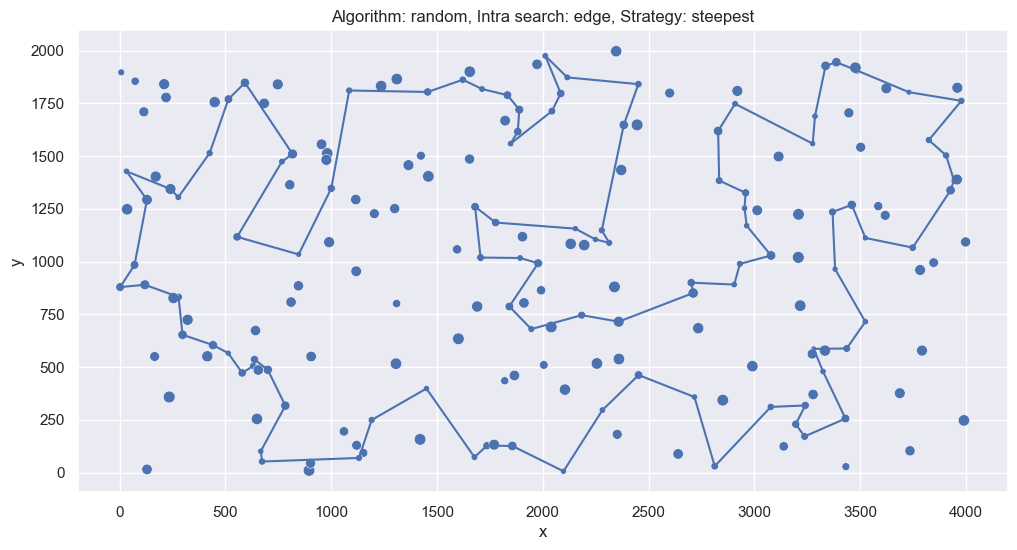

Best solution: [4, 149, 28, 20, 60, 148, 47, 94, 66, 179, 185, 99, 130, 95, 86, 166, 194, 176, 113, 103, 114, 137, 127, 89, 163, 187, 153, 81, 77, 141, 91, 61, 36, 78, 175, 142, 5, 177, 21, 82, 111, 8, 104, 138, 11, 139, 182, 25, 136, 80, 190, 73, 54, 31, 193, 117, 198, 156, 1, 121, 51, 90, 131, 135, 63, 40, 107, 122, 133, 10, 147, 6, 188, 169, 132, 70, 3, 155, 15, 145, 13, 195, 168, 33, 160, 29, 0, 109, 35, 143, 106, 124, 62, 18, 55, 34, 170, 152, 183, 140]
Time to calculate: 93.4562
Objective function statistics:
minimum = 45193
mean = 46542.57
maximum = 47682


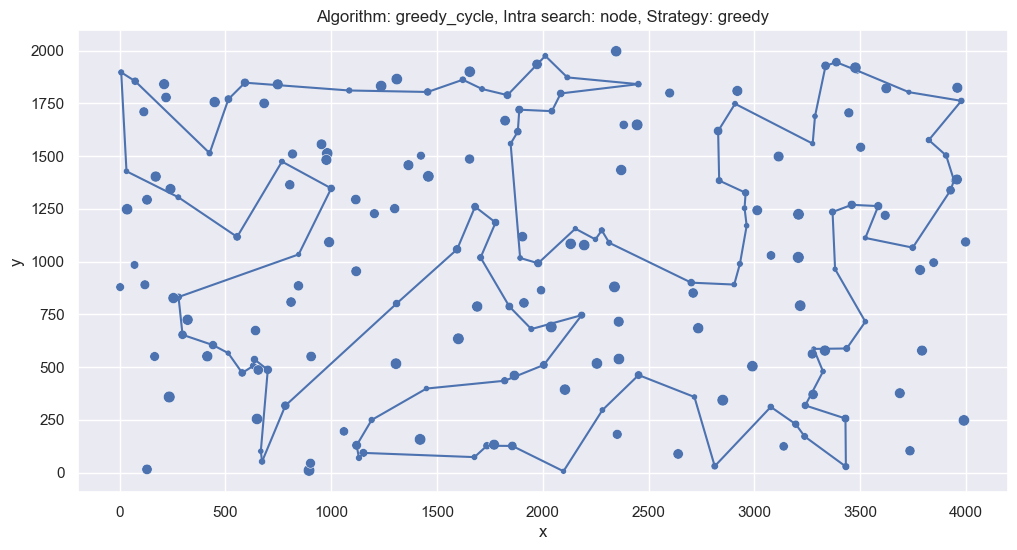

Best solution: [4, 149, 28, 20, 60, 148, 47, 94, 66, 179, 185, 99, 130, 95, 86, 166, 194, 176, 113, 103, 114, 137, 127, 89, 163, 187, 153, 81, 77, 141, 91, 61, 36, 78, 175, 142, 5, 177, 21, 82, 111, 8, 104, 138, 11, 139, 182, 25, 136, 80, 190, 73, 54, 31, 193, 117, 198, 156, 1, 121, 51, 90, 131, 135, 63, 40, 107, 122, 133, 10, 147, 6, 188, 169, 132, 70, 3, 155, 15, 145, 13, 195, 168, 33, 160, 29, 0, 109, 35, 143, 106, 124, 62, 18, 55, 34, 170, 152, 183, 140]
Time to calculate: 87.4384
Objective function statistics:
minimum = 45193
mean = 46537.475
maximum = 47682


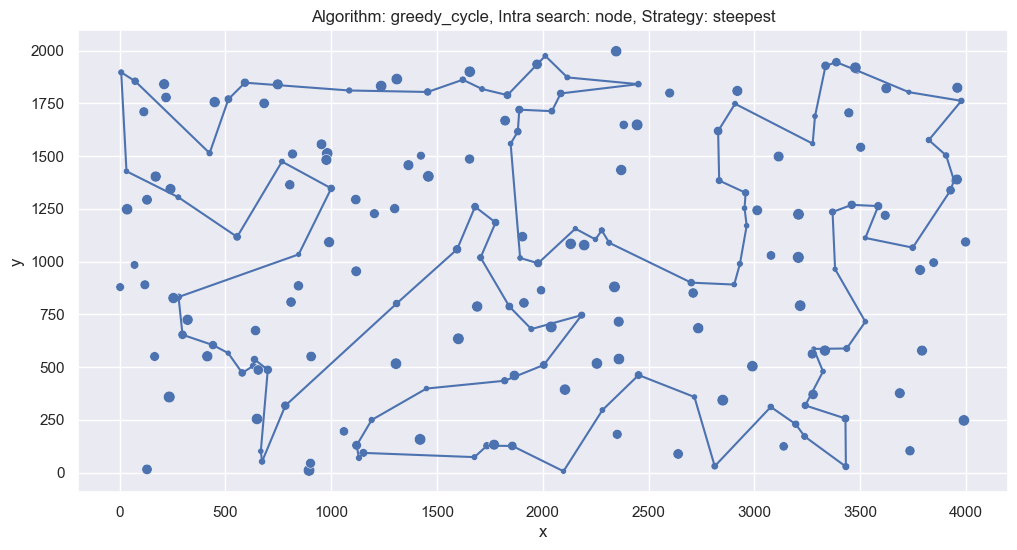

Best solution: [47, 94, 66, 179, 185, 99, 130, 95, 86, 166, 194, 176, 113, 103, 114, 137, 127, 89, 163, 187, 153, 81, 77, 141, 91, 61, 36, 5, 45, 142, 78, 175, 80, 190, 73, 54, 31, 193, 117, 198, 156, 1, 121, 51, 90, 131, 135, 63, 40, 107, 122, 133, 10, 147, 6, 188, 169, 132, 70, 3, 155, 15, 145, 13, 195, 168, 139, 11, 138, 182, 25, 177, 21, 82, 111, 8, 104, 33, 160, 29, 0, 109, 35, 143, 106, 124, 62, 18, 55, 34, 170, 152, 183, 140, 4, 149, 28, 20, 60, 148]
Time to calculate: 116.7871
Objective function statistics:
minimum = 44532
mean = 45790.74
maximum = 47373


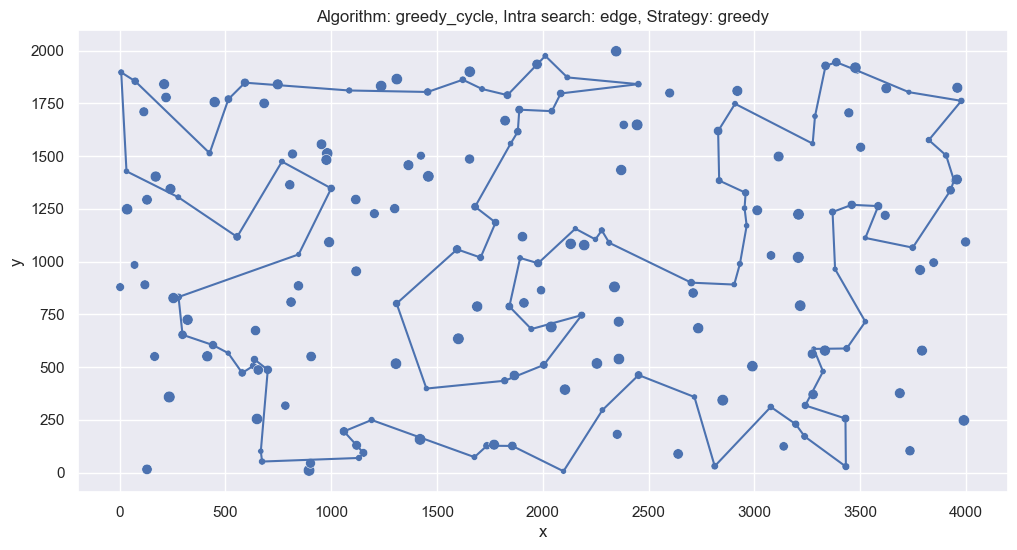

Best solution: [4, 149, 28, 20, 60, 148, 47, 94, 66, 179, 185, 99, 130, 95, 86, 166, 194, 176, 113, 103, 114, 137, 127, 89, 163, 187, 153, 81, 77, 141, 91, 61, 36, 5, 78, 175, 45, 80, 190, 136, 73, 54, 31, 193, 117, 198, 156, 1, 121, 51, 90, 131, 135, 63, 40, 107, 122, 133, 10, 147, 6, 188, 169, 132, 70, 3, 155, 15, 145, 13, 195, 168, 139, 11, 138, 182, 25, 177, 21, 82, 111, 8, 104, 33, 160, 29, 0, 109, 35, 143, 106, 124, 62, 18, 55, 34, 170, 152, 183, 140]
Time to calculate: 111.9318
Objective function statistics:
minimum = 44472
mean = 45564.175
maximum = 47045


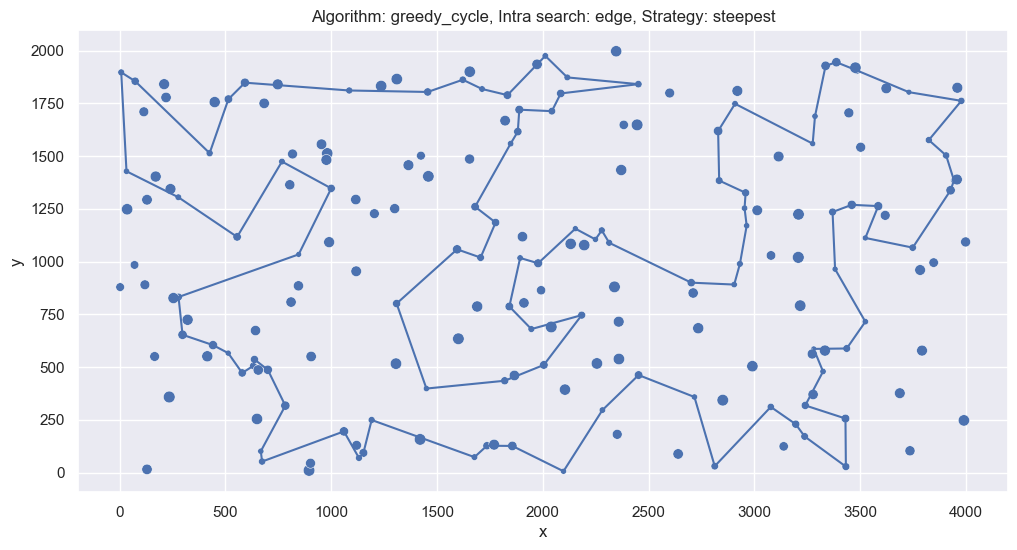

In [19]:
for algo in algos:
    for search in intra_search:
        for strat in strategy:
            experiment(
                dataset_B,
                distance_matrix_B,
                f"Algorithm: {algo}, Intra search: {search}, Strategy: {strat}",
                init_local_search,
                **{
                    "strategy": strat,
                    "intra_search": search,
                    "debug_mode": True,
                    "algo_to_enchance": algo,
                },
            )